# 02 - Normal vs. Deaf

## Imports

In [1]:
import avn.dataloading as dataloading
import avn.acoustics as acoustics
import avn.plotting as plotting
import avn.segmentation as segmentation
import avn.syntax as syntax

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import librosa
import os

from numpy.fft import fft, fftfreq
from scipy.signal.windows import hann
import scipy.signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

c:\Users\tkoch\anaconda3\envs\fresh_avn_dev\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Normal and Iso Dataset

In [2]:
all_feats_normal = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\all_birds_all_feats_wseg_umap_updated.csv').drop(columns = 'Unnamed: 0')

## Load Wada Lab Deaf Birds

In [4]:
all_feats_deaf = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\wada_birds_all_feats.csv').drop(columns = 'Unnamed: 0')

In [5]:
all_feats_deaf

,Goodness_mean_median,Goodness_mean_min,Goodness_mean_max,Mean_frequency_mean_median,Mean_frequency_mean_min,Mean_frequency_mean_max,Entropy_mean_median,Entropy_mean_min,Entropy_mean_max,Amplitude_mean_median,...,rhythm_entropy,CV_peak_rhythm_spectrum_frequency,syllable_duration_entropy,gap_duration_entropy,entropy_rate,entropy_rate_norm,num_syllables,mean_repetition_length,CV_repetition_length,Condition
0,0.117747,0.114967,0.121071,2155.357576,2109.599981,2867.423096,-3.266155,-3.448087,-3.060742,61.694346,...,-0.142866,6.848818,0.795698,0.679239,2.085816,0.695272,7,1.180929,0.341734,deaf_120
1,0.138719,0.134799,0.143075,1916.063608,1905.271892,1967.627065,-3.067501,-3.118677,-2.831167,60.048020,...,-0.420613,4.462123,0.623511,0.596916,1.073634,0.415338,5,6.325758,0.855042,deaf_300
2,0.120487,0.115469,0.141427,1761.408783,1563.806841,3297.943880,-3.145204,-3.359798,-2.939603,56.802061,...,-0.186091,4.453035,0.661636,0.792669,2.322015,0.671213,10,2.047170,0.529954,deaf_120
3,0.138086,0.123512,0.146133,1756.748116,1433.786306,2007.303591,-3.356677,-3.532446,-2.834024,56.994473,...,-0.890552,4.523146,0.439880,0.786990,1.312251,0.413969,8,1.200000,0.381881,deaf_300
4,0.114786,0.104775,0.116830,1789.762898,1485.763158,2337.077138,-3.683179,-3.889325,-3.563164,54.013514,...,-0.229416,2.829038,0.684722,0.851385,2.736651,0.823814,9,1.807692,0.555234,deaf_120
5,0.140029,0.123126,0.163307,1837.666285,1569.842809,2464.989868,-2.950556,-3.258490,-2.657295,52.208152,...,-0.814188,3.042721,0.430952,0.581725,1.596453,0.503625,8,2.497939,0.711100,deaf_300
6,0.110085,0.102550,0.135041,2305.491632,1474.451575,3660.457968,-2.612077,-2.928364,-2.373068,52.716926,...,-0.145907,12.336573,0.740859,0.862666,2.236685,0.646547,10,1.750000,0.473804,deaf_120
7,0.131318,0.123017,0.143566,1944.922759,1834.077485,2438.096988,-2.865155,-3.101042,-2.670985,57.502545,...,-0.212056,4.376186,0.636782,0.828545,1.416925,0.504719,6,2.524590,0.623647,deaf_300
8,0.118705,0.113045,0.124365,1804.720076,1590.400913,2019.039239,-3.079158,-3.291822,-2.866493,49.660063,...,-0.176262,7.477644,0.593052,0.866371,0.778098,0.490925,2,5.219178,0.842512,deaf_120
9,0.170568,0.128027,0.179388,1705.981868,1661.570229,1956.193094,-3.513520,-3.598754,-3.245168,58.378313,...,-0.367510,4.838005,0.419097,0.669968,0.814732,0.350886,4,6.861111,0.639381,deaf_300


In [6]:
all_feats_deaf[['Bird_ID', 'Condition']]

,Bird_ID,Condition
0,green12_PH125,deaf_120
1,green12_PH320,deaf_300
2,green14_PH126,deaf_120
3,green14_PH349,deaf_300
4,green22_PH127,deaf_120
5,green22_PH352,deaf_300
6,green47_PH135,deaf_120
7,green47_PH345,deaf_300
8,green65_PH137,deaf_120
9,green65_PH360,deaf_300


In [6]:
all_feats_deaf['rhythm_entropy'] = 10**all_feats_deaf.rhythm_entropy

## Merge Datasets

In [7]:
all_feats = pd.concat([all_feats_normal, all_feats_deaf])

### Drop Amplitude Features

Amplitude features depend strongly on the specific recording conditions of a bird, and seem to vary strongly across colonies, so we will not consider these features in subsequent analyses. 

In [8]:
amplitude_features = all_feats.columns[['Amplitude' in x for x in all_feats.columns.tolist()]]

all_feats = all_feats.drop(columns= amplitude_features)

## Normalize Dataset

In [9]:
features_only = all_feats.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

scaler = StandardScaler()
scaler.fit(feature_mat)

StandardScaler()

In [10]:
all_feats.Condition.unique()

array(['Isolate', 'FP1_KD_post_tut', 'FP1_KD_pre_tut', 'GFP', 'Tutor',
       'Pupil', 'Rockefeller-Pupil', 'deaf_120', 'deaf_300',
       'sham-deafening'], dtype=object)

In [11]:
normal_and_deaf = all_feats[~all_feats.Condition.isin([ 'FP1_KD_pre_tut', 'Isolate', 'deaf_120'])]

In [12]:
features_only = normal_and_deaf.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

feature_mat_norm = scaler.transform(feature_mat)

In [13]:
class_dict = {'sham-deafening' : 0, 
              'deaf_300' : 1, 
              'FP1_KD_post_tut' : 0, 
              'GFP' : 0, 
              'Pupil' :  0, 
              'Tutor' : 0, 
              'Rockefeller-Pupil': 0,
              'Isolate' : 2, 
              'FP1_KD_pre_tut' : 3}

y = [class_dict[x] for x in normal_and_deaf.Condition]

## L1-Based Feature Selection

In [14]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [15]:
print(feature_mat_norm.shape)
lsvc = LinearSVC(C=0.1, penalty='l1', dual = False).fit(feature_mat_norm, y)
model_l1 = SelectFromModel(lsvc, prefit=True)
x_new = model_l1.transform(feature_mat_norm)
x_new.shape

(87, 43)


(87, 6)

Alright, so this cuts down our feature set from 43 to only 6 features. What are those features? 

In [16]:
feature_idx = [lsvc.coef_ != 0]
features = features_only.columns[np.squeeze(feature_idx)]

In [17]:
features

Index(['Goodness_mean_max', 'Mean_frequency_mean_max', 'duration_mean_min',
       'Mean_frequency_CV_min', 'duration_CV_min', 'CV_repetition_length'],
      dtype='object')

In [18]:
feature_weights = pd.DataFrame({'feature' : features_only.columns.values, 
                                'weight' : np.squeeze(lsvc.coef_)})
feature_weights['abs_weight'] = np.abs(feature_weights.weight)
feature_weights.sort_values('abs_weight', ascending=False).head(6)

,feature,weight,abs_weight
5,Mean_frequency_mean_max,-0.186419,0.186419
22,Mean_frequency_CV_min,0.151237,0.151237
34,duration_CV_min,0.123460,0.123460
16,duration_mean_min,-0.060371,0.060371
2,Goodness_mean_max,-0.020447,0.020447
42,CV_repetition_length,0.000525,0.000525


## Classification Accuracy with Reduced Feature Sets

In [19]:
model = LinearDiscriminantAnalysis()
model.fit(x_new, y)
X_transformed = model.transform(x_new)
X_transformed.shape

(87, 1)

In [20]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy.stats import sem

In [21]:
model = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats = 10, random_state=42)
scores = cross_val_score(model, X = x_new, y = y, scoring = 'accuracy', cv = cv, )

In [22]:
np.mean(scores)

0.993202614379085

In [23]:
sem(scores)

0.002630734488366479

## Plotting Feature Weights

In [24]:
model_LDA = LinearDiscriminantAnalysis()
model_LDA.fit(x_new, y)
X_transformed = model_LDA.transform(x_new)
X_transformed.shape

(87, 1)

In [25]:
model_LDA.coef_.flatten()

array([-2.20583585, -4.86394378, -3.64048268,  5.21625907,  4.58477223,
        1.98545362])

In [26]:
weights = pd.DataFrame(model_LDA.coef_.flatten(), index = features)
weights = weights.sort_values(by = 0, ascending= False)

In [29]:
plt.rcParams.update({'font.size': 8})

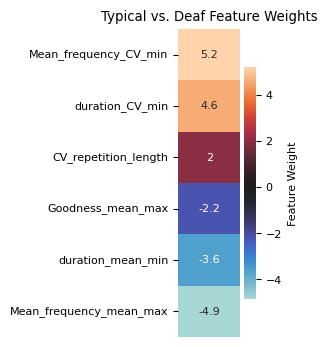

In [56]:
plt.figure(figsize=(1, 4))
sns.heatmap(weights, annot =True, center = 0, 
            cbar_kws={'label' : 'Feature Weight'})
plt.xticks([])
plt.title('Typical vs. Deaf Feature Weights')
plt.savefig('deaf_vs_typical_LDA_feature_weights.svg', transparent = True)

# Plot Groups along LD1

## Load UTSW Dataset

In [32]:
all_feats_normal = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\all_birds_all_feats_wseg_umap_updated.csv').drop(columns = 'Unnamed: 0')

In [33]:
all_feats.columns.to_frame().to_csv('LDA Features Table.csv')

## Load Wada Lab Deaf Birds

In [36]:
all_feats_deaf = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\All_features_2023\\All_features_2023\\wada_birds_all_feats.csv').drop(columns = 'Unnamed: 0')

In [37]:
all_feats_deaf

,Goodness_mean_median,Goodness_mean_min,Goodness_mean_max,Mean_frequency_mean_median,Mean_frequency_mean_min,Mean_frequency_mean_max,Entropy_mean_median,Entropy_mean_min,Entropy_mean_max,Amplitude_mean_median,...,rhythm_entropy,CV_peak_rhythm_spectrum_frequency,syllable_duration_entropy,gap_duration_entropy,entropy_rate,entropy_rate_norm,num_syllables,mean_repetition_length,CV_repetition_length,Condition
0,0.117747,0.114967,0.121071,2155.357576,2109.599981,2867.423096,-3.266155,-3.448087,-3.060742,61.694346,...,-0.142866,6.848818,0.795698,0.679239,2.085816,0.695272,7,1.180929,0.341734,deaf_120
1,0.138719,0.134799,0.143075,1916.063608,1905.271892,1967.627065,-3.067501,-3.118677,-2.831167,60.048020,...,-0.420613,4.462123,0.623511,0.596916,1.073634,0.415338,5,6.325758,0.855042,deaf_300
2,0.120487,0.115469,0.141427,1761.408783,1563.806841,3297.943880,-3.145204,-3.359798,-2.939603,56.802061,...,-0.186091,4.453035,0.661636,0.792669,2.322015,0.671213,10,2.047170,0.529954,deaf_120
3,0.138086,0.123512,0.146133,1756.748116,1433.786306,2007.303591,-3.356677,-3.532446,-2.834024,56.994473,...,-0.890552,4.523146,0.439880,0.786990,1.312251,0.413969,8,1.200000,0.381881,deaf_300
4,0.114786,0.104775,0.116830,1789.762898,1485.763158,2337.077138,-3.683179,-3.889325,-3.563164,54.013514,...,-0.229416,2.829038,0.684722,0.851385,2.736651,0.823814,9,1.807692,0.555234,deaf_120
5,0.140029,0.123126,0.163307,1837.666285,1569.842809,2464.989868,-2.950556,-3.258490,-2.657295,52.208152,...,-0.814188,3.042721,0.430952,0.581725,1.596453,0.503625,8,2.497939,0.711100,deaf_300
6,0.110085,0.102550,0.135041,2305.491632,1474.451575,3660.457968,-2.612077,-2.928364,-2.373068,52.716926,...,-0.145907,12.336573,0.740859,0.862666,2.236685,0.646547,10,1.750000,0.473804,deaf_120
7,0.131318,0.123017,0.143566,1944.922759,1834.077485,2438.096988,-2.865155,-3.101042,-2.670985,57.502545,...,-0.212056,4.376186,0.636782,0.828545,1.416925,0.504719,6,2.524590,0.623647,deaf_300
8,0.118705,0.113045,0.124365,1804.720076,1590.400913,2019.039239,-3.079158,-3.291822,-2.866493,49.660063,...,-0.176262,7.477644,0.593052,0.866371,0.778098,0.490925,2,5.219178,0.842512,deaf_120
9,0.170568,0.128027,0.179388,1705.981868,1661.570229,1956.193094,-3.513520,-3.598754,-3.245168,58.378313,...,-0.367510,4.838005,0.419097,0.669968,0.814732,0.350886,4,6.861111,0.639381,deaf_300


In [38]:
all_feats_deaf['rhythm_entropy'] = 10**all_feats_deaf.rhythm_entropy

## Merge Datasets

In [39]:
all_feats = pd.concat([all_feats_normal, all_feats_deaf])

In [40]:
all_feats = all_feats.rename(columns = {'entropy_rate_norm' : 'syntax_entropy_rate'})

### Drop Amplitude Features

Amplitude features depend strongly on the specific recording conditions of a bird, and seem to vary strongly across colonies, so we will not consider these features in subsequent analyses. 

In [41]:
amplitude_features = all_feats.columns[['Amplitude' in x for x in all_feats.columns.tolist()]]

all_feats = all_feats.drop(columns= amplitude_features)

## Normalize Dataset

In [42]:
normal_iso_deaf = all_feats[~all_feats.Condition.isin([ 'deaf_120'])]

In [43]:
features_only = normal_iso_deaf.drop(columns = ['Bird_ID', 'Condition', 'entropy_rate', 'num_syllables'])
feature_mat = features_only.values

feature_mat_norm = scaler.transform(feature_mat)

In [44]:
X_feat_subset= model_l1.transform(feature_mat_norm)
LD1_pred = model_LDA.transform(X_feat_subset)

In [45]:
lda_df = pd.DataFrame({'coord_x' : np.squeeze(LD1_pred), 
                        'condition' : normal_iso_deaf.Condition, 
                         'Bird_ID' : normal_iso_deaf.Bird_ID})

In [46]:
group_dict = {'deaf_300' : "Deaf", 
              'sham-deafening' : "Sham Deafening", 
              'deaf_120' : "Deaf Unstable",
              'FP1_KD_post_tut' : 'Typical UTSW', 
              'GFP' : 'Typical UTSW', 
              'Pupil' :  'Typical UTSW', 
              'Tutor' : 'Typical UTSW', 
              'Rockefeller-Pupil': 'Typical Rockefeller',
              'Isolate' : 'Isolate', 
              'FP1_KD_pre_tut' : 'FP1 KD'}
lda_df['Group'] = [group_dict[x] for x in lda_df.condition]

In [47]:
lda_df.head(2)

,coord_x,condition,Bird_ID,Group
0,0.804455,Isolate,B145,Isolate
1,-4.427250,Isolate,B236,Isolate


In [48]:
lda_df.Group = lda_df.Group.astype('category').cat.set_categories(['Isolate', 'FP1 KD', 'Deaf', 'Sham Deafening', 'Typical UTSW', 'Typical Rockefeller'], ordered = True)

c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 13.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Deaf vs. Typical LDA')

c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


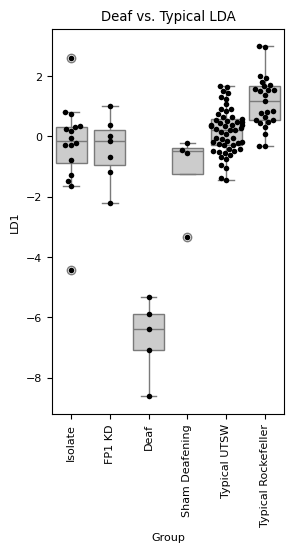

In [49]:
plt.figure(figsize = (3, 5))
sns.boxplot(data = lda_df, y = 'coord_x', x = 'Group', color = '0.8')
sns.swarmplot(data = lda_df, y = 'coord_x', x = 'Group', color = 'black', legend = False, s = 4)
plt.ylabel('LD1')
plt.xticks(rotation = 90)
plt.title('Deaf vs. Typical LDA')

In [51]:
palette = [sns.color_palette()[0], sns.color_palette()[2],sns.color_palette()[7],sns.color_palette()[5], 
           sns.color_palette()[1], 'crimson' ]

c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 37.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 35.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


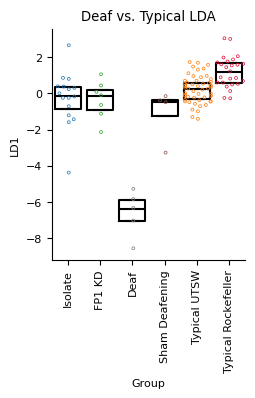

In [55]:
plt.figure(figsize = (2.5, 3))
sns.boxplot(data = lda_df, y = 'coord_x', x = 'Group', fill = False, color = 'black', 
            fliersize=0, whis= 0, 
            legend = False)
sns.swarmplot(data = lda_df, y = 'coord_x', x = 'Group', hue = 'Group', legend = False, s = 4, 
              palette = palette, marker = '$\circ$')
plt.ylabel('LD1')
plt.xticks(rotation = 90)
plt.title('Deaf vs. Typical LDA')
sns.despine()
plt.savefig('deaf vs typical LD1 all groups.svg', transparent = True)